# **2-2. Keras의 3대 AP**I - CNN



In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model

# data
from tensorflow.keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape

(60000, 28, 28)

CNN은 3D tensor를 입력으로 받으므로, 원래 데이터를 (-1, 높이, 넓이, 1) 로 reshape 해줘야한다! (MLP랑은 다름!)

In [5]:
num_labels=len(np.unique(y_train))

y_train=to_categorical(y_train)  # y를 범주화 
y_test=to_categorical(y_test)

shape1=x_train.shape[1]   
shape2=x_train.shape[2]

# mlp와는 다르게 reshape해준다! 
x_train=x_train.reshape(-1, shape1, shape2,1).astype('float32')   # 28*28 채널 1(흑백)이미지로 reshape(3d tensor) 
x_test=x_test.reshape(-1, shape1, shape2,1).astype('float32')

x_train=x_train/255
x_test=x_test/255

In [6]:
# 파라미터 설정!
input_shape = (shape1, shape2, 1)   # 28*28의 흑백 이미지
batch_size = 64  
kernel_size = 3  # 3*3 커널 사용
pool_size = 2   # pooling stride
filters = 64  # 노드의 숫자! 
dropout = 0.3

### 1) Sequential API

- Conv 2D로 3D 이미지를 적합

In [22]:
model = Sequential()
# 맨 처음 레이어는 input shape을 꼭 지정한다!
model.add(Conv2D(filters = 64, kernel_size = 3, activation='relu', input_shape= input_shape))  # ((3*3)*1 + 1)64
model.add(MaxPooling2D(2))   # stride 2로 pooling (모수없음)

model.add(Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same'))   # ((3*3)*64+1 )64 =  36928    
model.add(MaxPooling2D(2))   # stride 2로 pooling

model.add(Conv2D(filters=64, kernel_size = 3, activation='relu'))  # ((3*3)*64 +1) 64 = 36928
model.add(Flatten()) # MLP layer 입력을 위함
model.add(Dropout(0.3))  # 0.7만큼만 학습에 사용

model.add(Dense(num_labels, activation='softmax'))   
model.summary()

## 패딩을 안하니까 shape이 26>13 이런식으로 줄고있는 모습
# 640 + 36928 + 36928 + 5770 = 전체 모수 수

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

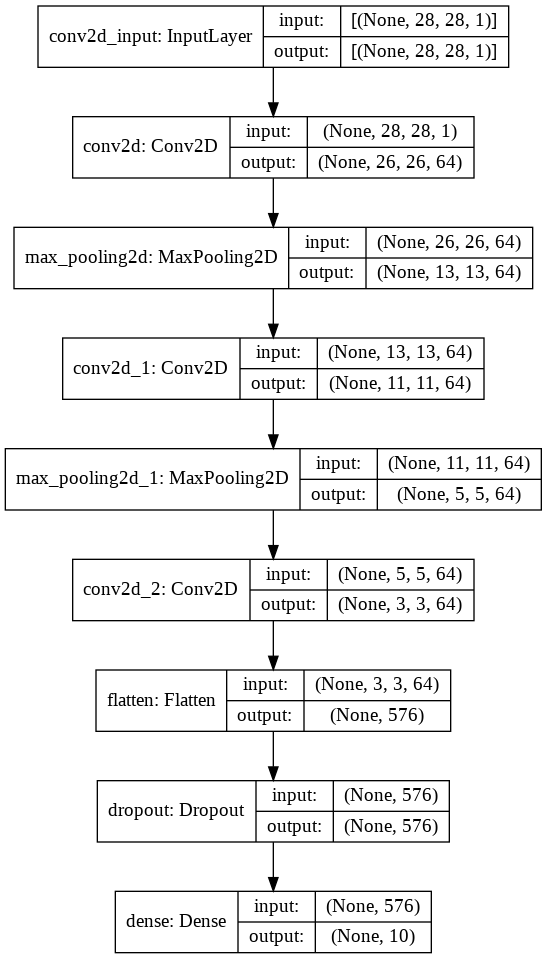

In [11]:
plot_model(model, show_shapes=True)

In [13]:
x_train.shape

(60000, 28, 28, 1)

In [12]:
# 모델 compile
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64)   # 60000/64 = 937.5 이므로 937번 배치가 돈다

Epoch 1/10
938/938 [==============================] - 20s 3ms/step - loss: 0.4586 - accuracy: 0.8553
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0582 - accuracy: 0.9816
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0442 - accuracy: 0.9854
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0360 - accuracy: 0.9884
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0293 - accuracy: 0.9903
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0256 - accuracy: 0.9920
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0212 - accuracy: 0.9931
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0178 - accuracy: 0.9940
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0147 - accuracy: 0.9953
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0152 - accuracy: 0.995

In [16]:
results = model.evaluate(x_test, y_test)
print(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.0262 - accuracy: 0.9924
[0.02621692232787609, 0.9923999905586243]


### 2) Functional API

In [18]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model

input_shape = (shape1, shape2, 1)   # 28*28의 흑백 이미지
batch_size = 64  
kernel_size = 3  # 3*3 커널 사용
pool_size = 2   # pooling stride
filters = 64  # 노드의 숫자! 
dropout = 0.3

# input 지정
x = Input(shape=input_shape)
h = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
h = MaxPooling2D()(h)   # pooling default는 2
h = Conv2D(filters = 64, kernel_size = 3, activation='relu')(h)
h = MaxPooling2D()(h)
h = Conv2D(filters = 64, kernel_size=3, activation='relu')(h)
h = Flatten()(h)
h = Dropout(0.3)(h)

# output 지정
out = Dense(num_labels, activation='softmax')(h)

# Model layer를 따로 지정해주기(input과 output으로!)
model = Model(inputs=x, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0     

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.4737 - accuracy: 0.8476
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0688 - accuracy: 0.9786
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0448 - accuracy: 0.9857
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0378 - accuracy: 0.9881
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0306 - accuracy: 0.9901
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0298 - accuracy: 0.9908
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0237 - accuracy: 0.9920
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0182 - accuracy: 0.9938
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0181 - accuracy: 0.9946
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0153 - accuracy: 0.9951

# **2-3. Keras의 3대 API** - RNN

### 1) Sequential API



In [24]:
from tensorflow.keras.datasets import mnist

(x_train,y_train),(x_test,y_test)=mnist.load_data()
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
shape1=x_train.shape[1]
shape2=x_train.shape[2]
x_train=x_train.reshape(-1, shape1,shape2).astype('float32') #RNN의 입력은 표본을 포함하여 3D 텐서임
x_test=x_test.reshape(-1, shape1,shape2).astype('float32')
x_train=x_train/255.
x_test=x_test/255.

In [25]:
from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN
input_shape = (shape1, shape2)

model = Sequential()
model.add(SimpleRNN(units=256, dropout=0.2, input_shape=input_shape))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               72960     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 75,530
Trainable params: 75,530
Non-trainable params: 0
_________________________________________________________________
